# Step 3: Clustering + Model Exploration

In this notebook, dataset is visualized and clustered, and some classification models are explored.

First, dimensionality reduction is done using PCA and UMAP. This serves two purposes - to visualize the data, and to try to increase training speed and reduce overfitting.

Data reduced to 3 dimentions is visualized to get a better understanding of how it is distributed and if there are any intrinsic patterns. This helps in forming the classification strategy. The interactive plots are stored as html files in the img directory.

Since human-understandable visualization is limited to 3 dimensions, clustering methods are used to look for inherent patterns and clusterings. If well defined clusters are formed, then these methods could also be used for classification.

Finally, some models are implemented and tested. These include SVM, Adaboost SVM Ensemble, XGBoost, and RGF. The models may or may not be able to learn well from a dataset reduced using PCA or UMAP, but it's worth a shot.

The following models will be explored in future versions:
1. Neural network
2. Classifiers based on embeddings learned from semi-supervised UMAP

In [1]:
import os
import gc
import datetime
import cloudpickle

import scipy
import numpy as np

import seaborn as sns
import plotly

import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client
from joblib import parallel_backend

from umap import UMAP
from sklearn.decomposition import PCA
from dask_ml.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import DistanceMetric
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN

from sklearn.svm import SVC
from rgf.sklearn import RGFClassifier
from dask_ml.xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import (
    confusion_matrix,
    homogeneity_completeness_v_measure,
    precision_recall_fscore_support,
)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
# start a local Dask client
# use the daskboard at http://localhost:8787/status
# NOTE: ProgressBar does not show up when client is initialized
client = Client()

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning:


Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.



In [4]:
# inferred int64 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
}

In [5]:
# read all the cleaned seagate data into one dataframe
DATA_DIR = "/home/kachauha/Downloads/data_Q4_2018_clean"
seagate_df = dd.read_csv(os.path.join(DATA_DIR, "*.csv"), dtype=custom_dtypes)

In [6]:
# get the serial numbers for all the failed hard drives
failed_serials = seagate_df[seagate_df["failure"] == 1]["serial_number"]

## Collapse Time Dimension

Most of the classification models discussed cannot be directly applied to time series data, especially considering that the time series may be of different lengths. Therefore, time series are reduced to fixed-length feature vectors.

The simplest and easiest method of collapsing time dimension is implemented for now. See https://trello.com/c/kIoGk9T1 for a full list of representation techniques that could be explored.

In [7]:
# collapse time dim, drop cols that are unncessary for train data
seagate_df_grouped = seagate_df.drop(["date", "failure"], axis=1).groupby(
    "serial_number"
)

# characterize a time series by simple stats - mean,std,max,min,size,kurtosis
means = seagate_df_grouped.mean()
means = means.rename(columns={col: "mean_" + col for col in means.columns})

stds = seagate_df_grouped.std(ddof=0)
stds = stds.rename(columns={col: "std_" + col for col in stds.columns})
stds = stds.fillna(0)  # FIXME: std returns nans even for ddof=0

# maxs = seagate_df_grouped.max()
# maxs = maxs.rename(columns={col: 'max_' + col for col in maxs.columns})

# mins = seagate_df_grouped.min()
# mins = mins.rename(columns={col: 'min_' + col for col in mins.columns})

days = seagate_df_grouped.size().to_frame("days")

In [8]:
# join stats into one df
X_df = means.merge(right=stds, left_index=True, right_index=True)
# X_df = X_df.merge(right=maxs, left_index=True, right_index=True)
# X_df = X_df.merge(right=mins, left_index=True, right_index=True)
X_df = X_df.merge(right=days, left_index=True, right_index=True)

In [9]:
# convert to dask array - some algos dont like dataframes
X_arr = X_df.to_dask_array(lengths=True)

In [ ]:
# sanity check - ensure no nans
X_df.isna().any().any().compute()

In [10]:
# clean up memory
del means
del stds
del days
gc.collect()

1181

In [11]:
# get ground truth labels
# NOTE: dask-xgboost needs this to be dask obejct
# NOTE: if not converted to dask array, it is of nan shape
Y_arr = da.from_array(X_df.index.isin(failed_serials.values.compute()).compute())
Y_arr.shape

(82993,)

In [12]:
# true if drive had failed. used for indexing into Xtrain dask array
failed_idx = (Y_arr == 1).compute()
failed_idx.sum()

341

## Preprocess

In [13]:
std_scaler = StandardScaler()
# rob_scaler = RobustScaler()

X_arr = std_scaler.fit_transform(X_arr)
# X = rob_scaler.fit_transform(X)

## Save preprocessed

In [20]:
da.to_npy_stack("preprocessed/X_arr", X_arr)
da.to_npy_stack("preprocessed/Y_arr", Y_arr)

## Visualize

In [23]:
# vanilla pca for visualization in 3d
with parallel_backend("dask"):
    pcs = PCA(n_components=3)
    X_pca = pcs.fit_transform(X_arr)

In [57]:
# plot
working_pca = dict(
    mode="markers",
    name="Working",
    type="scatter3d",
    x=X_pca[~failed_idx, 0],
    y=X_pca[~failed_idx, 1],
    z=X_pca[~failed_idx, 2],
    marker=dict(size=2, color="rgb(0, 0, 200)"),
)

failed_pca = dict(
    mode="markers",
    name="Failed",
    type="scatter3d",
    x=X_pca[failed_idx, 0],
    y=X_pca[failed_idx, 1],
    z=X_pca[failed_idx, 2],
    marker=dict(size=2, color="rgb(200, 0, 0)"),
)

layout_pca = dict(
    title="Simple Reduction Euclidean PCA",
    scene=dict(
        xaxis=dict(zeroline=False),
        yaxis=dict(zeroline=False),
        zaxis=dict(zeroline=False),
    ),
)

In [56]:
fig = dict(data=[working_pca, failed_pca], layout=layout_pca)
plotly.offline.plot(
    fig, filename="../reports/figures/pca/seagate_simple_euclidean.html", auto_open=True
)

'seagate_pca_scatter.html'

In [ ]:
#################################################################
#   KERNEL PCA RUNS OUT OF MEMORY for rbf, sigmoid, cosine      #
#################################################################
# # euclidean is not good enough for the dims we have. go nonlinear
# with parallel_backend('dask'):
#     kpca = KernelPCA(n_components=3, kernel='cosine', random_state=42)
#     X_kpca = kpca.fit_transform(X_arr)

In [ ]:
# # plot
# working_kpca = dict(
#     mode = "markers",
#     name = "Working",
#     type = "scatter3d",
#     x = X_kpca[~failed_idx, 0],
#     y = X_kpca[~failed_idx, 1],
#     z = X_kpca[~failed_idx, 2],
#     marker = dict( size=2, color="rgb(0, 0, 200)" )
# )

# failed_kpca = dict(
#     mode = "markers",
#     name = "Failed",
#     type = "scatter3d",
#     x = X_kpca[failed_idx, 0],
#     y = X_kpca[failed_idx, 1],
#     z = X_kpca[failed_idx, 2],
#     marker = dict( size=2, color="rgb(200, 0, 0)" )
# )

# layout_kpca = dict(
#     title = 'Simple Reduction RBF PCA',
#     scene = dict(
#         xaxis = dict( zeroline=False ),
#         yaxis = dict( zeroline=False ),
#         zaxis = dict( zeroline=False ),
#     )
# )

In [ ]:
# fig = dict( data=[working_kpca, failed_kpca], layout=layout_kpca )
# plotly.offline.plot(fig, filename='seagate_kpca_rbf.html', auto_open=True)

In [40]:
# visualize using umap (tsne may be too expensive)
with parallel_backend("dask"):
    ucs = UMAP(n_components=3, metric="canberra", n_neighbors=32, random_state=42)
    X_umap = ucs.fit_transform(X_arr, y=da.where(Y_arr == 0, -1, Y_arr))

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^


/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/umap/umap_.py:569: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "categorical_simplicial_set_intersection" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/p

In [41]:
# plot
working_umap = dict(
    mode="markers",
    name="Working",
    type="scatter3d",
    x=X_umap[~failed_idx, 0],
    y=X_umap[~failed_idx, 1],
    z=X_umap[~failed_idx, 2],
    marker=dict(size=2, color="rgb(0, 0, 200)"),
)

failed_umap = dict(
    mode="markers",
    name="Failed",
    type="scatter3d",
    x=X_umap[failed_idx, 0],
    y=X_umap[failed_idx, 1],
    z=X_umap[failed_idx, 2],
    marker=dict(size=2, color="rgb(200, 0, 0)"),
)

layout_umap = dict(
    title="Simple Reduction Canberra UMAP, Semisupervised",
    scene=dict(
        xaxis=dict(zeroline=False),
        yaxis=dict(zeroline=False),
        zaxis=dict(zeroline=False),
    ),
)

In [42]:
fig = dict(data=[working_umap, failed_umap], layout=layout_umap)
plotly.offline.plot(
    fig, filename="../reports/figures/umap/seagate_n32_canberra_ss.html", auto_open=True
)

'seagate_umapn32_canberra_ss.html'

## Reduce Data
Since UMAP seems to be creating useful embeddings, we can use the embeddings as the reduced dataset and classify on that instead. There is some description of this method in the original paper, and a lot of description and documentation in umap-learn

In [156]:
# keep 20 out of 67 dimensions
feat_reducer = UMAP(
    n_components=20, metric="chebyshev", n_neighbors=15, random_state=42
)
X_umap = feat_reducer.fit_transform(X_arr)

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^


/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



## Dask Model Saving Utility

Since models could be either dask models or sklearn models, using just pickle or joblib may not suffice because dask models contain delayed objects. Therefore, models are saved using cloudpickle, which has been tested to work (for trivial cases, at least).

In [14]:
def save_model(model, fname, suffix=None):
    """Serialize and save a dask or sklearn model

    Arguments:
        model {dask_ml or sklearn object} -- trained model to save
        fname {str} -- name of file to write to

    Keyword Arguments:
        suffix {str} -- suffix in the filename (default: {None})
                        This serves as the identifier of the current
                        state of the model
                        If not provided, the current timestamp is used
    """
    # generate default suffix if needed
    if suffix is None:
        suffix = datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S")

    # serialize and write
    with open(fname + "_" + suffix + ".cpkl", "wb") as file:
        cloudpickle.dump(model, file)

## Split Data for Models

Since there is a large class imbalance in the dataset, the splitting must be done such that the percentages of classes in the splits is the same as those in the overall data.

In [24]:
# split the original dataset
with parallel_backend("dask"):
    X_train, X_test, Y_train, Y_test = train_test_split(X_arr, Y_arr, stratify=Y_arr)

In [ ]:
# split the reduced dataset
with parallel_backend("dask"):
    X_train_umap, X_test_umap, Y_train_umap, Y_test_umap = train_test_split(
        X_umap, Y_arr, stratify=Y_arr
    )

## Clusters

### Distance Based

In [93]:
with parallel_backend("dask"):
    for k in range(2, 10):
        # find kmeans clusters for current k
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_arr)

        # get metrics for current k
        h, c, v = homogeneity_completeness_v_measure(Y_train, km.labels_)
        print("========================================")
        print("k={}: H={}, C={}, V={}".format(k, h, c, v))
        print("conf mat:")
        print(confusion_matrix(Y_train, km.labels_))

k= 2: H=6.848515299160378e-05, C=1.9800378535589948e-05, V=3.071923405442396e-05
conf mat:
[[81119  1533]
 [  336     5]]
k= 3: H=0.00037707201658545404, C=0.00010120982184295491, V=0.0001595853681000266
conf mat:
[[81118  1338   196]
 [  336     5     0]
 [    0     0     0]]
k= 4: H=0.0004120967325706981, C=0.00010087610130649623, V=0.00016207763451594342
conf mat:
[[81118   908   148   478]
 [  336     4     0     1]
 [    0     0     0     0]
 [    0     0     0     0]]
k= 5: H=0.0004702256468091204, C=0.00011183461948498203, V=0.0001806943690480539
conf mat:
[[81089   906   149   478    30]
 [  336     4     0     1     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]]
k= 6: H=0.00044448513054675645, C=9.974303213248817e-05, V=0.00016292539673169366
conf mat:
[[81089   624   130   326   454    29]
 [  336     3     0     1     1     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0   

In [16]:
with parallel_backend("dask"):
    for k in range(2, 6):
        # find kmeans clusters for current k
        sc = SpectralClustering(n_clusters=k, random_state=42)
        sc.fit(X_arr)

        # get metrics for current k
        h, c, v = homogeneity_completeness_v_measure(Y_train, sc.labels_)
        print("========================================")
        print("k={}: H={}, C={}, V={}".format(k, h, c, v))
        print("conf mat:")
        print(confusion_matrix(Y_train, sc.labels_))

MemoryError: 

### Density Based
To use density based clkustering, we must find a good metric and its "threshold" value for points belonging in a cluster. This requires tuning.

In [25]:
man = DistanceMetric.get_metric("manhattan")
X_df.index.head()

Index(['6VDHZ9H9', '6VDHZAKY', '6VDHZATY', '6VDHZAXD', '6VDHZB48'], dtype='object', name='serial_number')

In [36]:
foo = X_df.loc["6VDHZAXD", :].compute()
bar = X_df.loc["6VDHZATY", :].compute()

scipy.spatial.distance.cityblock(foo, bar)

38.522346242013505

In [39]:
with parallel_backend("dask"):
    for epsilon in range(1, 6):
        # find kmeans clusters for current k
        db = DBSCAN(metric="manhattan", eps=epsilon)
        db.fit(X_arr)

        # get metrics for current k
        h, c, v = homogeneity_completeness_v_measure(Y_train, db.labels_)
        print("========================================")
        print("e={}: H={}, C={}, V={}".format(epsilon, h, c, v))
        print("conf mat:")
        print(confusion_matrix(Y_train, db.labels_))

e=1: H=0.0040969275756273325, C=0.0005331403538892181, V=0.0009435012404910959
conf mat:
[[    0     0     0 ...     0     0     0]
 [80478     5    11 ...     5     6     4]
 [  341     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]
e=2: H=0.1669530204593021, C=0.0017809033841935226, V=0.00352421365383619
conf mat:
[[    0     0     0 ...     0     0     0]
 [26300 13254   119 ...     5     3     3]
 [  337     1     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]
e=3: H=0.32776595457007096, C=0.004098996279768483, V=0.008096735885950135
conf mat:
[[    0     0     0 ...     0     0     0]
 [ 8132 16991    21 ...    21     5     5]
 [  331     4     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0  

## NOTE
All the following models except svm have been fit on the entire dataset. They all do poorly (cant overfit).

## XGBoost (vanilla + UMAP reduced)

In [30]:
# vanilla classifier
xgbc = XGBClassifier(max_depth=6, random_state=42)
xgbc.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
preds = xgbc.predict(X_train)
confusion_matrix(Y_train.compute(), preds.compute())

array([[    0, 82652],
       [    0,   341]])

In [33]:
# reduced data classifier
xgbc_umap = XGBClassifier(max_depth=6, random_state=42)
# xgbc_umap = XGBClassifier(learning_rate=0.1,
#                                max_depth=3,
#                                min_child_weight=0.5,
#                                reg_lambda=0.01,
#                                reg_alpha=0.01,
#                                random_state=42)
xgbc_umap.fit(da.from_array(X_train_umap), Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
preds = xgbc_umap.predict(da.from_array(X_train_umap))
confusion_matrix(Y_train.compute(), preds.compute())

array([[    0, 82652],
       [    0,   341]])

In [35]:
gc.collect()

2649

## SVM

In [76]:
with parallel_backend("dask"):
    svc = SVC(C=5, class_weight="balanced", probability=True, random_state=42)
    svc.fit(X_train, Y_train)

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [77]:
with parallel_backend("dask"):
    prob_preds_train = svc.predict_proba(X_train)
    prob_preds_test = svc.predict_proba(X_test)

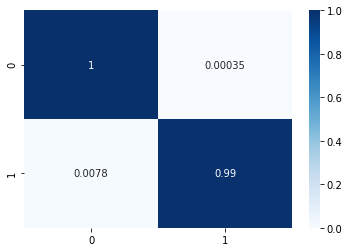

In [78]:
# threshold probability for model train on all data = ~0.3
TRAIN_THRESHOLD_PROBA = 0.5

# how well did it fit on the train data
confmat_train = confusion_matrix(
    Y_train, prob_preds_train[:, 1] > TRAIN_THRESHOLD_PROBA
)
sns.heatmap(
    confmat_train / confmat_train.sum(axis=1, keepdims=True),
    vmin=0,
    vmax=1,
    annot=True,
    cmap="Blues",
)

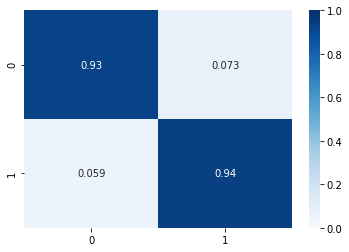

In [84]:
# how well does it generalize
TEST_THRESHOLD_PROBA = 0.005
confmat_test = confusion_matrix(Y_test, prob_preds_test[:, 1] > TEST_THRESHOLD_PROBA)
sns.heatmap(
    confmat_test / confmat_test.sum(axis=1, keepdims=True),
    vmin=0,
    vmax=1,
    annot=True,
    cmap="Blues",
)

In [149]:
# grid search for best threshold proba
for prob in np.arange(0.33, 0.36, 0.005):
    curr_preds = prob_preds_test[:, 1] > prob
    p, r, f, _ = precision_recall_fscore_support(
        y_true=Y_test, y_pred=curr_preds, average="binary"
    )
    print("p={:2f}, prec={:2f}, rec={:2f}, f={:2f}".format(prob, p, r, f))

p=0.330000, prec=0.656716, rec=0.517647, f=0.578947
p=0.335000, prec=0.676923, rec=0.517647, f=0.586667
p=0.340000, prec=0.671875, rec=0.505882, f=0.577181
p=0.345000, prec=0.671875, rec=0.505882, f=0.577181
p=0.350000, prec=0.666667, rec=0.494118, f=0.567568
p=0.355000, prec=0.672131, rec=0.482353, f=0.561644


## SVM Ensemble

In [ ]:
with parallel_backend("dask"):
    # init adaboosted ensemble of svm classifiers
    ada_base_learner = SVC(
        C=2.5, class_weight="balanced", probability=True, random_state=42
    )
    ada_clf = AdaBoostClassifier(
        base_estimator=ada_base_learner,
        n_estimators=100,
        learning_rate=0.5,
        random_state=42,
    )
    # training time
    ada_clf.fit(X_train, Y_train)

In [ ]:
# how well did it do
with parallel_backend("dask"):
    ada_probs_train = ada_clf.predict_proba(X_train)
    ada_probs_test = ada_clf.predict_proba(X_test)

In [ ]:
TRAIN_THRESHOLD_PROBA = 0.5
ada_confmat_train = confusion_matrix(
    Y_train, ada_probs_train[:, 1] > TRAIN_THRESHOLD_PROBA
)
sns.heatmap(
    ada_confmat_train / ada_confmat_train.sum(axis=1, keepdims=True),
    vmin=0,
    vmax=1,
    annot=True,
    cmap="Blues",
)

In [ ]:
TEST_THRESHOLD_PROBA = 0.005
ada_confmat_test = confusion_matrix(Y_test, ada_probs_test[:, 1] > TEST_THRESHOLD_PROBA)
sns.heatmap(
    ada_confmat_test / ada_confmat_test.sum(axis=1, keepdims=True),
    vmin=0,
    vmax=1,
    annot=True,
    cmap="Blues",
)

## RGF

In [25]:
rgfc = RGFClassifier(max_leaf=5000, l2=1e-10, learning_rate=0.01)
rgfc.fit(X_train, Y_train)

KeyboardInterrupt: 

In [27]:
%%time
with parallel_backend("dask"):
    rgfc = RGFClassifier(max_leaf=5000, l2=1e-10, learning_rate=0.01)
    rgfc.fit(X_train, Y_train)

CPU times: user 17.7 s, sys: 2.03 s, total: 19.8 s
Wall time: 6min 59s


In [ ]:
with parallel_backend("dask"):
    rgf_prob_preds_train = rgfc.predict_proba(X_train)
    rgf_prob_preds_test = rgfc.predict_proba(X_test)

In [ ]:
# threshold probability for model test on all data = ~0.3
TEST_THRESHOLD_PROBA = 0.5

# how well did it fit on the test data
rgf_confmat_test = confusion_matrix(
    Y_test, rgf_prob_preds_test[:, 1] > TEST_THRESHOLD_PROBA
)
sns.heatmap(
    rgf_confmat_test / rgf_confmat_test.sum(axis=1, keepdims=True),
    vmin=0,
    vmax=1,
    annot=True,
    cmap="Blues",
)

## Hyperparameter Tuning for RGF

The hyperparameter tuning is done using MLflow and OpenShift (see repos [experiment-tracking](https://github.com/chauhankaranraj/experiment-tracking) and [training](https://github.com/chauhankaranraj/training)). After tuning the hyperparameters, the RGF model performs very well on the dataset. 

**We conclude that RGF is the best model thus far.**

The best parameters are as follows:
1. l2 = 1e10
2. learning_rate = 0.1
3. loss = "Log"
4. max_leaf = 5000 
5. others = default

and the corresponding performance metrics on the test dataset (size: (0.2 x 82993, 67)) are as follows:
1. log_loss = 0.003
2. precision = 0.985
3. recall = 0.941
4. f1_score = 0.962